In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-lowest-aic452022/dataset_lowestAIC_longlat.csv
/kaggle/input/datasetlowestaicspatialglobal/dataset_lowestAIC_longlat.csv


In [2]:
#import dataset 
df = pd.read_csv(r'../input/datasetlowestaicspatialglobal/dataset_lowestAIC_longlat.csv', sep=';')

## Data processing

In [3]:
#remove geodata
df = df.drop(['Longitude', 'Latitude'], axis=1)

In [4]:
df.head()

,mean_value_NO2,nightlight_450,nightlight_3150,population_1000,population_3000,road_class_2_25,road_class_3_3000,road_class_3_300,trop_mean_filt_2019,BldDen100,NDVI,trafBuf25,trafBuf50
0,29.250500,22.585377,13.402575,8123.319336,54316.64453,0.000000,203502.42190,4167.064941,0.000058,1.000663,2310.0,0.000000,0.000000
1,32.098936,23.546194,22.862799,9558.207031,76786.28125,0.000000,99596.04688,1850.278076,0.000081,0.978245,2518.0,0.000000,0.000000
2,58.703744,18.290140,16.493486,10471.541020,88439.60938,46.359188,265563.71880,2016.838379,0.000076,0.914638,3216.0,674.791667,674.791667
3,24.249276,23.645823,18.248226,11165.945310,76961.00000,0.000000,97921.56250,478.363281,0.000074,0.712983,1052.0,0.000000,0.000000
4,19.912116,14.026642,5.514785,6017.511230,30814.58984,0.000000,176265.68750,3338.221191,0.000047,1.000641,3240.0,0.000000,0.000000


In [5]:
#remove NAs and replace with 0
df=df.fillna(0)

In [6]:
y = df['mean_value_NO2']
x = df.drop(['mean_value_NO2'], axis=1)
feature_list = list(x.columns)

In [7]:
                         ## Import the (modules of) models we are using
        
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import lightgbm as lgb


In [8]:
#models

#Non-linear

#Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, min_samples_split=10,
                          min_samples_leaf=5,max_features=4,max_depth=10, bootstrap=True )

#LightGBM
lightgbm_model = lgb.LGBMRegressor(reg_alpha =2, reg_lambda = 0, max_depth = 5, learning_rate = 0.0005, n_estimators =50000, random_state=42)
#XGBoost
xgb= xgb.XGBRegressor(gamma = 5,  reg_alpha =2, reg_lambda=0, max_depth = 5, learning_rate = 0.0005, n_estimators=50000, random_state=42)


#linear models

#Lasso
model_lasso = Lasso(alpha=0.1)
#Ridge
ridge2 = Ridge(alpha = 0.3, normalize = True)


In [9]:
#random states - CV = 20
random_states = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] #random state is needed to ensure that same results are generated each time.
#models
models = [rf, lightgbm_model, xgb, model_lasso, ridge2]
#model_names
model_names = ['rf', 'lgb', 'xgb', 'lasso', 'ridge']

In [10]:
print(models)

[RandomForestRegressor(max_depth=10, max_features=4, min_samples_leaf=5,
                      min_samples_split=10, n_estimators=1000, random_state=42), LGBMRegressor(learning_rate=0.0005, max_depth=5, n_estimators=50000,
              random_state=42, reg_alpha=2, reg_lambda=0), XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=5, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0005, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=50000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=2, reg_lambda=0, ...

In [11]:
#construct cross-validation via loop


#create dictionaries that eventually stores performance per model (CV)
total_rmse = {}
total_r2 = {}
total_mae = {}

rmse_vals_round = []
#start with first model
for i,k in zip(models,model_names):
    #initialize lists where performances can be stored to
    locals()[str(k)+"RMSE_scores"] = []
    locals()[str(k)+"R2_scores"] = []
    locals()[str(k)+"MAE_scores"] = []
    print(" ")
    print("next model:", str(k))
    print(" ")
#     for j in range(0, len(random_states)):
    for j in random_states:    
        #split dataset into training- and testing dataset
        X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=j)
        print(j)
        #train the model
        i.fit(X_train, Y_train)
#         print(X_train)
        
        #predict based on the training data
        preds_test = i.predict(X_test)
       
    
        ##RMSE
        #create function that calculates RMSE
        def rmse(predictions, targets):
            return np.sqrt(((predictions - targets) ** 2).mean())

        print('RMSE testing: ', rmse(preds_test, Y_test))
        rmse_val = rmse(preds_test, Y_test)
        #store result to list
        locals()[str(k)+"RMSE_scores"].append(rmse_val)
        
    
        ##R2
        print('R2 score testing: ', r2_score(Y_test, preds_test))
        r2_val = r2_score(Y_test, preds_test)
        #store result to list
        locals()[str(k)+"R2_scores"].append(r2_val)
    
        ##MEAN ABSOLUTE ERROR 
        print('MAE testing: ', mean_absolute_error(Y_test, preds_test))
        mae_val = mean_absolute_error(Y_test, preds_test)
        #store result to list
        locals()[str(k)+"MAE_scores"].append(mae_val)

    #store to dictionary
    total_rmse[k] = locals()[str(k)+"RMSE_scores"]
    total_r2[k] = locals()[str(k)+"R2_scores"]
    total_mae[k] = locals()[str(k)+"MAE_scores"]


 
next model: rf
 
1
RMSE testing:  6.4610896984544945
R2 score testing:  0.6994221428650933
MAE testing:  4.625926669509603
5
RMSE testing:  6.654373816151249
R2 score testing:  0.7667136993123488
MAE testing:  4.767613780656911
10
RMSE testing:  6.549017645224474
R2 score testing:  0.7044980464600284
MAE testing:  4.723503232130336
15
RMSE testing:  8.252973274881956
R2 score testing:  0.6449145066950697
MAE testing:  5.744435958478335
20
RMSE testing:  7.7274381581081375
R2 score testing:  0.6736700230316868
MAE testing:  5.570951647522141
25
RMSE testing:  7.66194652172493
R2 score testing:  0.6527255672934432
MAE testing:  5.425343108809896
30
RMSE testing:  6.089531418828927
R2 score testing:  0.7556934658131746
MAE testing:  4.32498908898097
35
RMSE testing:  5.769899751704938
R2 score testing:  0.7819140892547365
MAE testing:  4.102509313707015
40
RMSE testing:  7.365005970781685
R2 score testing:  0.6611276176450603
MAE testing:  5.413524731330514
45
RMSE testing:  6.869328095

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipel

In [12]:
#examine
print(total_rmse)
print(total_r2)
print(total_mae)

{'rf': [6.4610896984544945, 6.654373816151249, 6.549017645224474, 8.252973274881956, 7.7274381581081375, 7.66194652172493, 6.089531418828927, 5.769899751704938, 7.365005970781685, 6.869328095601385, 7.595382834064505, 7.1785581766480515, 6.86126389249909, 7.434268234376639, 6.145201679716776, 6.581079218082541, 6.711962023159544, 6.650808194607422, 7.312030467590125, 7.053604049132621], 'lgb': [6.976767444197125, 7.020956917123351, 6.6647980000655975, 8.408098599204575, 7.763328742160422, 8.218780723852378, 6.619006466024785, 6.092605052120545, 7.347988460544557, 6.758133048339935, 8.025395800445626, 7.796298296015083, 7.113726927292045, 7.195796377171202, 6.5324127399876355, 6.887649679159873, 7.293781882466139, 6.525792877968878, 7.988434302876868, 7.418978740149511], 'xgb': [6.75784752850612, 6.770224136270204, 7.13514061270918, 8.432717297954827, 7.9817577545942004, 8.362673933598353, 7.1870933030425155, 5.672767689491854, 6.912358977255286, 6.831813776606228, 7.974433698924336, 7.

In [13]:
#convert to pandas dataframes
df_total_rmse = pd.DataFrame(total_rmse)
df_total_r2 = pd.DataFrame(total_r2)
df_total_mae = pd.DataFrame(total_mae)

In [14]:
#examine
df_total_rmse.head(10)

,rf,lgb,xgb,lasso,ridge
0,6.461090,6.976767,6.757848,6.465851,6.201189
1,6.654374,7.020957,6.770224,7.513069,7.247263
2,6.549018,6.664798,7.135141,6.693194,6.131638
3,8.252973,8.408099,8.432717,8.229711,8.263073
4,7.727438,7.763329,7.981758,8.679330,8.553150
5,7.661947,8.218781,8.362674,7.502350,7.209355
6,6.089531,6.619006,7.187093,6.927226,6.197956
7,5.769900,6.092605,5.672768,6.266670,5.898374
8,7.365006,7.347988,6.912359,7.074355,6.982397
9,6.869328,6.758133,6.831814,6.999705,6.918554


In [15]:
#examine cross-validation root mean square error per model
df_total_rmse.describe()

,rf,lgb,xgb,lasso,ridge
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,6.946238,7.232437,7.287582,7.376521,7.024166
std,0.623684,0.635094,0.647564,0.643824,0.754219
min,5.769900,6.092605,5.672768,6.266670,5.898374
25%,6.573064,6.734799,6.892223,6.916876,6.320493
50%,6.865296,7.154762,7.196407,7.507710,7.053262
75%,7.382322,7.771571,7.700089,7.671080,7.334924
max,8.252973,8.408099,8.432717,8.679330,8.553150


In [16]:
#examine
df_total_r2.head()

,rf,lgb,xgb,lasso,ridge
0,0.699422,0.649528,0.671177,0.698979,0.723118
1,0.766714,0.740303,0.758520,0.702621,0.723291
2,0.704498,0.693957,0.649238,0.691344,0.740963
3,0.644915,0.631440,0.629279,0.646913,0.644045
4,0.673670,0.670632,0.651837,0.588321,0.600204


In [17]:
#examine cross-validation r2 per model
df_total_r2.describe()

,rf,lgb,xgb,lasso,ridge
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.706359,0.680502,0.675859,0.669145,0.700206
std,0.050082,0.061871,0.060406,0.054353,0.054519
min,0.597522,0.525273,0.526784,0.541993,0.594119
25%,0.670534,0.645006,0.648819,0.636602,0.654399
50%,0.703761,0.683605,0.671910,0.683309,0.710995
75%,0.754290,0.735720,0.712745,0.699890,0.747745
max,0.781914,0.761727,0.789195,0.744389,0.772094


In [18]:
#examine cross-validation mean absolute error per model
df_total_mae.describe()

,rf,lgb,xgb,lasso,ridge
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,4.865491,5.051606,5.007255,5.462367,5.098415
std,0.447930,0.416054,0.452261,0.405786,0.459367
min,4.102509,4.353840,3.978348,4.758324,4.308783
25%,4.553091,4.760435,4.736543,5.172270,4.748872
50%,4.769302,5.034098,4.976739,5.413267,5.075961
75%,5.193194,5.259714,5.178266,5.754867,5.424082
max,5.744436,5.940912,5.991755,6.344171,6.168760


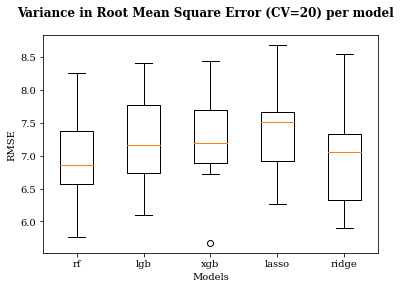

In [19]:
import matplotlib.pyplot as plt

#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()

fig.suptitle('Variance in Root Mean Square Error (CV=20) per model', fontsize=12, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_rmse)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('RMSE')

plt.savefig('RMSE - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))
plt.show()


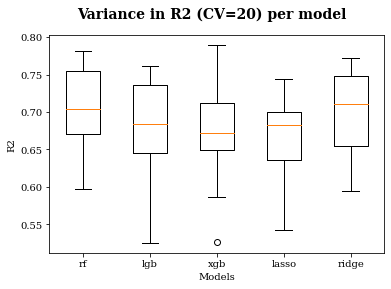

In [20]:
#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()
fig.suptitle('Variance in R2 (CV=20) per model', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_r2)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('R2')

plt.savefig('R2 - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))

plt.show()

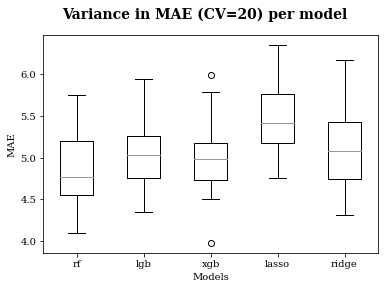

In [21]:
#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()
fig.suptitle('Variance in MAE (CV=20) per model', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_mae)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('MAE')

plt.savefig('MAE - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))

plt.show()